In [21]:
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from torch.autograd import Variable

import torchvision

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm import tqdm

from model import NN, FashionCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Using FashionMNIST class from torchvision module.

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
print("Train data shape: ", train_data.data.shape)
print("Test data shape: ", test_data.data.shape)

Train data shape:  torch.Size([60000, 28, 28])
Test data shape:  torch.Size([10000, 28, 28])


In [ ]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=100, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=100, 
                                          shuffle=False)

In [4]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [5]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

tensor(9)


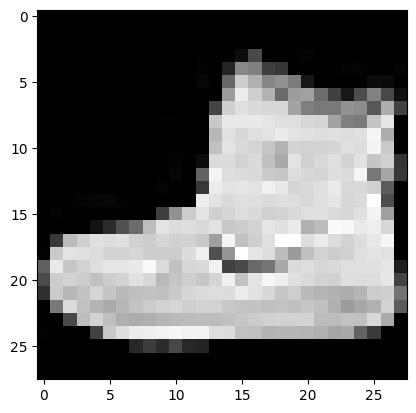

In [6]:
image, label = next(iter(train_loader))
plt.imshow(image[0].squeeze(), cmap="gray")
print(label[0])

In [7]:
demo_loader = torch.utils.data.DataLoader(train_data, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

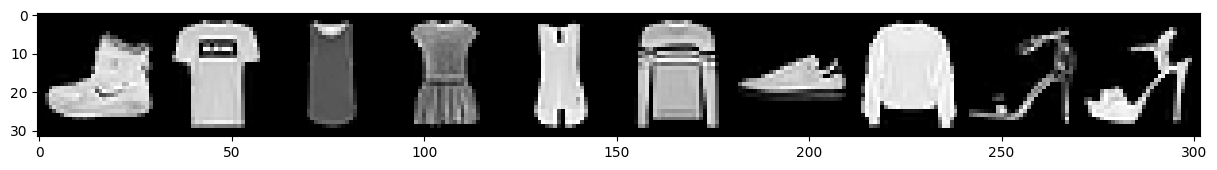

In [8]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

## Building a CNN 


*   Make a model class (FashionCNN in our case)
    * It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Batch Normalization layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 3 Fully connected layer  with different in/out features.
     * 1 Dropout layer that has class probability p = 0.25.
  
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:
        * First Convulation layer : input: 28 \* 28 \* 3, output: 28 \* 28 \* 32
        * First Max Pooling layer : input: 28 \* 28 \* 32, output: 14 \* 14 \* 32
        * Second Conv layer : input : 14 \* 14 \* 32, output: 12 \* 12 \* 64
        * Second Max Pooling layer : 12 \* 12 \* 64, output:  6 \* 6 \* 64
    * Final fully connected layer has 10 output features for 10 types of clothes.

In [9]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [10]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy:.2f}%")

/home/RAI_65011278/.local/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4341200888156891, Accuracy: 88.00%
Iteration: 1000, Loss: 0.3400772511959076, Accuracy: 88.10%
Iteration: 1500, Loss: 0.26589158177375793, Accuracy: 88.84%
Iteration: 2000, Loss: 0.2444094717502594, Accuracy: 89.32%
Iteration: 2500, Loss: 0.14217272400856018, Accuracy: 89.33%
Iteration: 3000, Loss: 0.18851205706596375, Accuracy: 90.97%


Visualizing the Loss and Accuracy with Iterations

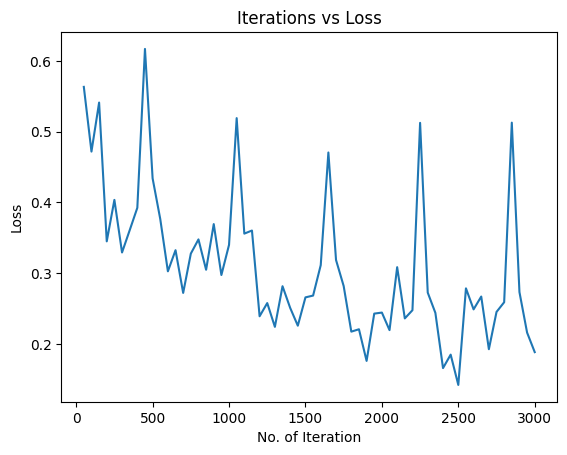

In [17]:
# plt.plot(iteration_list, accuracy_list)
# plt.plot(iteration_list.cpu().numpy(), loss_list.cpu().numpy())

# Convert lists to tensors
iteration_tensor = torch.tensor(iteration_list)
loss_tensor = torch.tensor(loss_list)
accuracy_tensor = torch.tensor(accuracy_list)

# Move tensors to CPU and convert to numpy arrays
plt.plot(iteration_tensor.cpu().numpy(), loss_tensor.cpu().numpy())
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

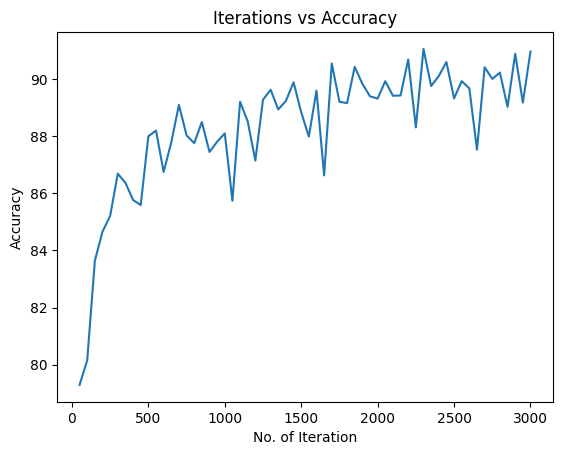

In [18]:
# plt.plot(iteration_list, accuracy_list)

plt.plot(iteration_tensor.cpu().numpy(), accuracy_tensor.cpu().numpy())
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

Looking the Accuracy in each class of FashionMNIST dataset

In [19]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

/home/RAI_65011278/.local/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of T-shirt/Top: 86.90%
Accuracy of Trouser: 97.90%
Accuracy of Pullover: 83.70%
Accuracy of Dress: 95.00%
Accuracy of Coat: 81.70%
Accuracy of Sandal: 97.00%
Accuracy of Shirt: 72.50%
Accuracy of Sneaker: 97.40%
Accuracy of Bag: 98.70%
Accuracy of Ankle Boot: 96.40%


Printing the Confusion Matrix

In [20]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [22]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     60000
           1       0.98      0.98      0.98     60000
           2       0.83      0.82      0.83     60000
           3       0.88      0.89      0.88     60000
           4       0.80      0.82      0.81     60000
           5       0.97      0.96      0.96     60000
           6       0.70      0.66      0.68     60000
           7       0.93      0.94      0.94     60000
           8       0.96      0.97      0.97     60000
           9       0.95      0.95      0.95     60000

    accuracy                           0.88    600000
   macro avg       0.88      0.88      0.88    600000
weighted avg       0.88      0.88      0.88    600000


